### Backtest Hyperfitting

In [1]:
import numpy as np
#import cupy  #Requires Cuda environment (and numpy). Also set CUPY_CACHE_DIR=/gpfs/gpfs0/deep/cupy, pip install cupy-cuda112
import pandas as pd
import matplotlib.pylab as plt
import itertools
from FinancialMachineLearning.metrics.metrics import getExpectedMaxSR, getDistMaxSR, getMeanStdError

In [2]:
nTrials = list(set(np.logspace(1, 6, 100).astype(int))) #only 100 iterations, in book - 1000
nTrials.sort()
sr0 = pd.Series({i:getExpectedMaxSR(i, meanSR = 0, stdSR = 1) for i in nTrials}, name = "E[max{SR}] (prior)") #prior
sr1 = getDistMaxSR(nSims = 100, nTrials = nTrials, meanSR = 0, stdSR = 1) #observed

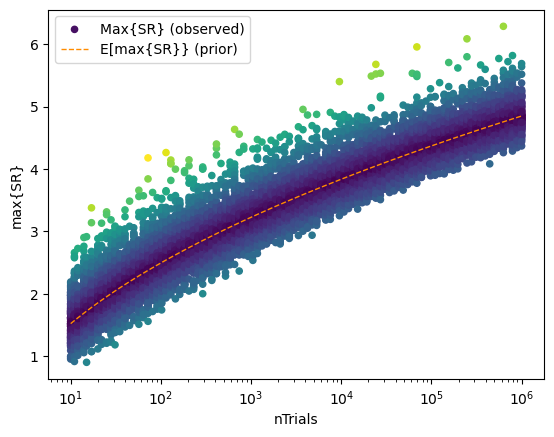

In [3]:
nnSR0 = list(itertools.chain.from_iterable(itertools.repeat(x, 100) for x in sr0.values))
deviationFromExpectation = abs(sr1['max{SR}'] - nnSR0)

ax = sr1.plot.scatter(
    x = 'nTrials', 
    y = 'max{SR}', 
    label = 'Max{SR} (observed)', 
    c = deviationFromExpectation
) #c: Array of values to use for marker colors.
ax.set_xscale('log')
ax.grid(False)
ax.plot(nTrials, sr0, linestyle = '--', linewidth=1, label = 'E[max{SR}} (prior)', color = 'darkorange')
plt.legend()
ax.figure.savefig('maxSR_across_uniform_strategies.png')

시행 횟수가 증가할수록 Sharpe Ratio는 필연적으로 증가한다. 이를 두고 백테스트 초과적합이라고 한다

In [4]:
nTrials = list(set(np.logspace(1, 6, 100).astype(int)))
nTrials.sort()
stats = getMeanStdError(nSims0 = 100, nSims1 = 100, nTrials = nTrials, stdSR = 1)

In [11]:
stats

,meanErr,stdErr
nTrials,,
10,0.035743,0.021818
11,0.031340,0.021905
12,0.030836,0.021743
14,0.026905,0.022068
15,0.025784,0.020224
...,...,...
628029,0.002993,0.005244
705480,0.003181,0.005291
792482,0.003533,0.004943


Text(0.5, 1.0, 'test statistics (mean, std)')

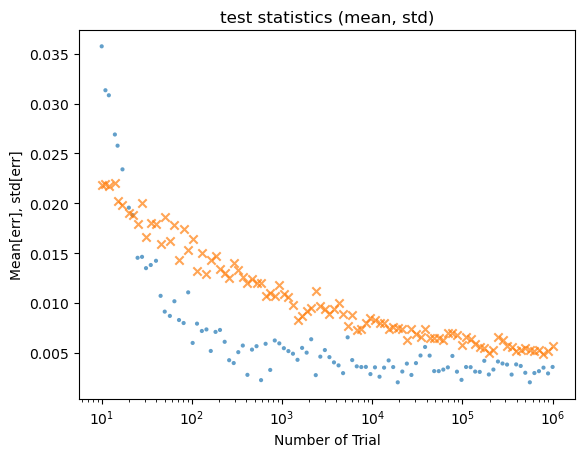

In [16]:
plt.scatter(stats.meanErr.index, stats.meanErr, marker = '.', alpha = 0.7, edgecolor = 'none')
plt.scatter(stats.stdErr.index, stats.stdErr, marker = 'x', alpha = 0.7)
plt.xscale('log')
plt.xlabel('Number of Trial')
plt.ylabel('Mean[err], std[err]')
plt.title('test statistics (mean, std)')
# ax.figure.savefig('fig82.png')

In [6]:
import scipy.stats as ss

def getZStat(sr, t, sr_=0, skew=0, kurt=3):
    z = (sr-sr_)*(t-1)**.5
    z /= (1-skew*sr+(kurt-1)/4.*sr**2)**.5
    return z

def type1Err(z, k=1):
    #false positive rate
    alpha = ss.norm.cdf(-z)
    alpha_k = 1-(1-alpha)**k #multi-testing correction
    return alpha_k

# code snippet 8.4 - Type II error (false negative) - with numerical example
def getTheta(sr, t, sr_=0., skew=0., kurt=3):
    theta = sr_*(t-1)**.5
    theta /= (1-skew*sr+(kurt-1)/.4*sr**2)**.5
    return theta

def type2Err(alpha_k, k, theta):
    #false negative rate
    z = ss.norm.ppf((1-alpha_k)**(1./k)) #Sidak's correction
    beta = ss.norm.cdf(z-theta)
    return beta

In [7]:
t, skew, kurt, k, freq = 1250, -3, 10, 10, 250
sr = 1.25/freq ** .5
sr_ = 1./freq ** .5
z = getZStat(sr, t, 0, skew, kurt)
alpha_k = type1Err(z, k=k)
print(alpha_k)

0.060760769078662125


In [8]:
t, skew, kurt, k, freq = 1250, -3, 10, 10, 250
sr = 1.25/freq**.5
sr_ = 1./freq**.5
z = getZStat(sr, t, 0, skew, kurt)
alpha_k = type1Err(z, k = k)
theta = getTheta(sr, t, sr_, skew, kurt)
beta = type2Err(alpha_k, k, theta)
beta_k = beta**k
print(beta_k)

0.039348420332089205
